# Summary figure of drainage density, incision for multiple model runs

In [50]:
import string
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

In [51]:
pl.rcParams['mathtext.default'] = 'regular'

In [52]:
fn = 'model_results/model_results_34_runs_100000yrs_sensitivity_all_id_311_1-4-2021.csv'

In [53]:
today = datetime.datetime.now()
today_str = '%i-%i-%i' % (today.day, today.month, today.year)

## Read files

In [54]:
df = pd.read_csv(fn)

In [55]:
## Remove values T < 1e-4 where the wattertable is fully at the surface

In [56]:
df = df.loc[df['T'] >= 1e-4]

## Figure out changed parameters

In [57]:
#changed_params = []


cols = df.columns.tolist()
cols = [c for c in cols if 'Unnamed' not in c]

input_cols = cols[:cols.index('n_streams')]

nus = np.array([len(df[col].unique()) for col in input_cols])

changed_param_ind = np.where(nus > 1)[0]
changed_params = [input_cols[ci] for ci in changed_param_ind] 

#changed_params.append(changed_param)
   
print('changed parameters in model sensitivity runs:')
print(changed_params)

changed parameters in model sensitivity runs:
['K_d', 'P', 'S_init', 'T', 'n', 'specific_yield']


In [58]:
param_labels = []

param_labels_in = ['T', 'K_d', 'P', 'S_init', 'specific_yield', 'n']
param_labels_out = ['transmissivity', 'hillslope diffusion coefficient', 'precipitation',
                    'stream slope', 'Specific yield', 'slope exponent']

for changed_param in changed_params:
    if changed_param in param_labels_in:
        xlabel = param_labels_out[param_labels_in.index(changed_param)]
    else:
        xlabel = changed_param
        
    param_labels.append(xlabel)
    
print('parameter labels: ', param_labels)

parameter labels:  ['hillslope diffusion coefficient', 'precipitation', 'stream slope', 'transmissivity', 'slope exponent', 'Specific yield']


In [59]:
## Sort params with decreasing stream density change

In [60]:
sd_change = np.zeros(len(changed_params))

for i, changed_param in enumerate(changed_params):
    # assume first model run is the base case
    base_param = df.iloc[0][changed_param]
    
    sensitivity_runs_id = df[changed_param] != base_param
    
    stream_density = df.loc[sensitivity_runs_id, 'stream_density_str_per_km'].values
    
    sd_change[i] = np.max(stream_density) - np.min(stream_density)
    
a = np.argsort(sd_change)

changed_params = [changed_params[ai] for ai in a][::-1]
param_labels = [param_labels[ai]  for ai in a][::-1]

print(changed_params, param_labels)

['T', 'S_init', 'n', 'K_d', 'P', 'specific_yield'] ['transmissivity', 'stream slope', 'slope exponent', 'hillslope diffusion coefficient', 'precipitation', 'Specific yield']


In [61]:
import matplotlib

cmap = matplotlib.cm.get_cmap('tab10')

In [62]:
cmap(0.1)

(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)

## Make figure

saving figure as model_results/sensitivity_fig_6_params_2-4-2021.pdf


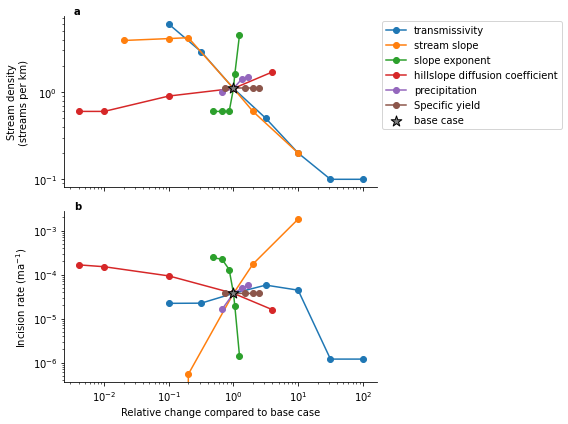

In [63]:
fig, axs = pl.subplots(2, 1, figsize=(8, 6), sharex=True)

lw = 1.5
s = 75

import matplotlib

cmap = matplotlib.cm.get_cmap('tab10')

colors = cmap(np.arange(0.0, 1.1, 0.1))

drainage_density_base = df.iloc[0]['stream_density_str_per_km']
incision_rate_base = df.iloc[0]['incision_rate_m_per_yr']

#for scenario_param_name in scenario_param_names:
for changed_param, param_label, color in zip(changed_params, param_labels, colors):
    
    # assume first model run is the base case
    base_param = df.iloc[0][changed_param]
    
    sensitivity_runs_id = df[changed_param] != base_param
    
    param_vals = df.loc[sensitivity_runs_id, changed_param].values
    
    #base_val = param_vals[0]
    drainage_density = df.loc[sensitivity_runs_id, 'stream_density_str_per_km']
    #wt_depth_avg
    incision_rate = df.loc[sensitivity_runs_id, 'incision_rate_m_per_yr']
    
    # add base case
    param_vals = np.append(param_vals, base_param)
    drainage_density = np.append(drainage_density, drainage_density_base)
    incision_rate = np.append(incision_rate, incision_rate_base)
    
    # sort values to get correct order
    sorder = np.argsort(param_vals)
    param_vals = param_vals[sorder]
    drainage_density = drainage_density[sorder]
    incision_rate = incision_rate[sorder]
    
    # show relative change
    param_val_relative = param_vals / base_param

    #axs[0].scatter(param_val_relative, drainage_density, edgecolor='black', facecolor=color, lw=lw, s=s, label=param_label)
    axs[0].plot(param_val_relative, drainage_density, color=color, lw=lw, label=param_label, marker='o')
    axs[0].set_ylabel('Stream density\n(streams per km)')
    #axs[0].set_xscale('log')
    
    
    #axs[1].scatter(param_val_relative, incision_rate, edgecolor='black', facecolor=color, lw=lw, s=s)
    axs[1].plot(param_val_relative, incision_rate, color=color, lw=lw, marker='o')
    axs[1].set_ylabel(r'Incision rate ($m a^{-1}$)')
    #axs[0].set_xscale('log')


axs[0].scatter(1.0, drainage_density_base, 
               edgecolor='black', facecolor='gray', marker='*', s=125, label='base case', zorder=100)
axs[1].scatter(1.0, incision_rate_base, 
               edgecolor='black', facecolor='gray', marker='*', s=125, zorder=100)

#axs[0].legend(frameon=False)

handles, labels = axs[0].get_legend_handles_labels()
lgd = axs[0].legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

for i, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.03, 1.0, string.ascii_lowercase[i], 
        weight='bold', transform=ax.transAxes, ha='left', va='bottom')
    ax.set_yscale('log')

axs[-1].set_xlabel('Relative change compared to base case')
axs[0].set_xscale('log')

#axs[0].set_ylim(8e-2, 1.1e+1)

fig.tight_layout()

fn = f'model_results/sensitivity_fig_{len(changed_params)}_params_{today_str}.pdf' 
print('saving figure as %s' % fn)

fig.savefig(fn)

(1e-07, 0.001)

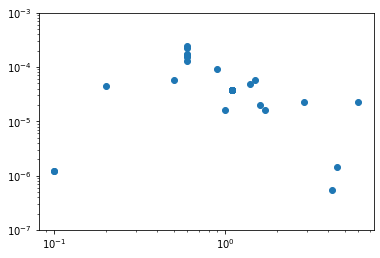

In [64]:
fig, ax = pl.subplots(1, 1)
#drainage_density_base = df.iloc[0]['stream_density_str_per_km']
#incision_rate_base = df.iloc[0]['incision_rate_m_per_yr']

ax.scatter(df['stream_density_str_per_km'],  df['incision_rate_m_per_yr'])

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(1e-7, 1e-3)